#**Working with the Functional vs. Sequential API**

I'm going to load the Boston Housing dataset again, just for demonstration purposes.

In [1]:
import tensorflow as tf
from tensorflow.keras.datasets import boston_housing
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np

(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

57026/57026 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


#*Simple, Feed-forward Topology*

Recall that we could specify a Sequential model as follows...

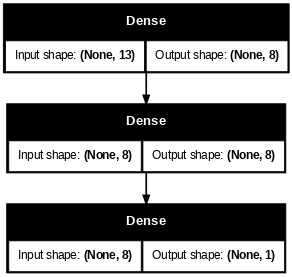

In [9]:
# Start the model... note that I can 'name' the model as part of this.
# I'm going to name my model here to avoid conflicts later, because I am going to redeclare another 'model' below using the Functional API
model = keras.Sequential(name="boston_housing")

# Add some layers... I can name those too.
# The Sequential API approach forces me to fully connect everything I add to the last layer of what I've done so far.
# It only alows a single pipe from input to output, of variable width.
model.add(layers.Input(shape=(train_data.shape[1],), name="inputs")) #-- notice I don't have to declare the input layer dimensions up front with Sequential API.
model.add(layers.Dense(8, activation="relu",name="first_hidden"))
model.add(layers.Dense(8, activation="relu",name="second_hidden"))
model.add(layers.Dense(1,name="output"))

# Compile the model.
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

# Draw a picture of the model...
keras.utils.plot_model(model,show_shapes=True,dpi=60)
#model.summary()

In [3]:
history = model.fit(train_data, train_targets, validation_split=0.2, epochs=20, batch_size=32, verbose=1)

Epoch 1/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 239.8184 - mae: 12.4868 - val_loss: 142.3110 - val_mae: 9.8172
Epoch 2/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 129.1741 - mae: 8.9193 - val_loss: 127.7239 - val_mae: 7.8091
Epoch 3/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 121.2114 - mae: 8.3527 - val_loss: 137.8143 - val_mae: 9.9701
Epoch 4/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 116.1514 - mae: 8.1156 - val_loss: 114.1122 - val_mae: 8.5217
Epoch 5/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 110.8784 - mae: 8.0635 - val_loss: 164.2364 - val_mae: 8.9220
Epoch 6/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 114.8339 - mae: 7.9830 - val_loss: 113.4369 - val_mae: 7.1230
Epoch 7/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 106.7828 - mae: 7.4608 - val_loss: 156.0343 - val_mae: 11.1020
Epoch 8/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 102.4199 - mae: 7.8546 - val_loss: 99.1721 - val_mae: 7.2503
Epoch 9/20
11/11 ━━━━━━━━━━━━━━

We can specify the exact same model using the Functional API, as follows...

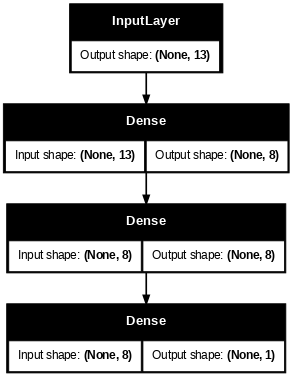

In [10]:
# I define my input layer, with shape = number of predictors in the data.
inputs = keras.layers.Input(shape=(train_data.shape[1],),name="inputs_v2")

# I then define the first hidden layer, which is connected to the prior input layer.
# I can connect the input layer to this, and I could connect some other layer...
first_hidden = keras.layers.Dense(8, activation="relu", name="first_hidden_v2")(inputs)
second_hidden = keras.layers.Dense(8, activation="relu", name="second_hidden_v2")(first_hidden)

# I then define my output layer, which connects to the hidden layer.
output = keras.layers.Dense(1, name="output_v2")(second_hidden)

# Finally, I feed the defined layer structure into a Keras model.
model = keras.Model(name="boston_housing_v2",inputs=[inputs],outputs=[output]) # be careful with what you name your model... spaces are a no-no

# Draw a picture of the model.
keras.utils.plot_model(model,show_shapes=True, dpi=60) # DPI controls the scale of the image when it renders.

#*More Complex Toplogy with Functional API*

Now we can use the functional API to make almost any topology we want, mixing and matching layers, and creating whatever branching logic we like...

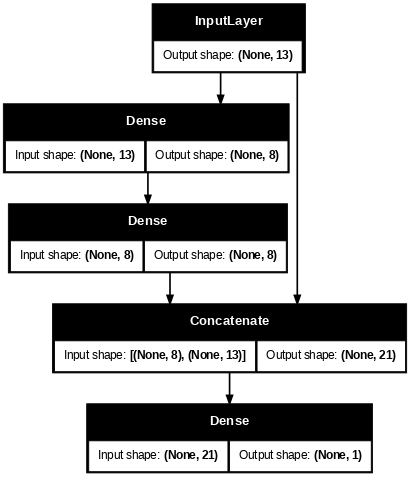

In [11]:
# I define my input layer, with shape = number of predictors in the data.
inputs_1 = keras.layers.Input(shape=(train_data.shape[1],),name="inputs_v3")

# I then define the first hidden layer, which is connected to the prior input layer.
# I can connect the input layer to this, and I could connect some other layer...
one_one_hidden = keras.layers.Dense(8, activation="relu", name="branch_one_one")(inputs)
one_two_hidden = keras.layers.Dense(8, activation="relu", name="branch_one_two")(one_one_hidden)

# I then define my output layer, which takes input from the prior set of hidden layers, in addition to taking the inputs directly as well.
# This is what's known as a residual connection.
merge = keras.layers.Concatenate()([one_two_hidden,inputs])
output = keras.layers.Dense(1, name="output_v3")(merge)

# Finally, I feed the defined layer structure into a Keras model.
model = keras.Model(name="boston_housing_v3",inputs=[inputs],outputs=[output])

# Draw a picture of the model.
keras.utils.plot_model(model,show_shapes=True,dpi=60)

For kicks, let's see how this model performs on the Boston Housing data. First, let's wrap the model build code inside a build function. Note that I'm adding a batch norm layer to whiten the inputs.

And, let's do the same cross-validation we did last time...

In [14]:
model.compile(loss="mse", optimizer="rmsprop", metrics=["mae"])

history = model.fit(train_data, train_targets,
                        validation_split=0.2,
                        epochs=20, batch_size=32, verbose=1)
mae_history = history.history['val_mae']

Epoch 1/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 8697.5674 - mae: 87.9718 - val_loss: 3449.0161 - val_mae: 54.6856
Epoch 2/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3394.3899 - mae: 53.2360 - val_loss: 1575.3136 - val_mae: 33.8077
Epoch 3/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1857.8672 - mae: 36.0712 - val_loss: 1047.2053 - val_mae: 26.6493
Epoch 4/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1370.0293 - mae: 29.6172 - val_loss: 747.2147 - val_mae: 21.9183
Epoch 5/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1157.8363 - mae: 27.0195 - val_loss: 530.2509 - val_mae: 17.7549
Epoch 6/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 851.7500 - mae: 22.4172 - val_loss: 418.6757 - val_mae: 14.4897
Epoch 7/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 689.0494 - mae: 19.6184 - val_loss: 304.8207 - val_mae: 13.3213
Epoch 8/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 525.9921 - mae: 17.3324 - val_loss: 254.1484 - val_mae: 13.2359
Epoch 9/20
11/

And, finally, plot the loss over the training process...

10.445966720581055


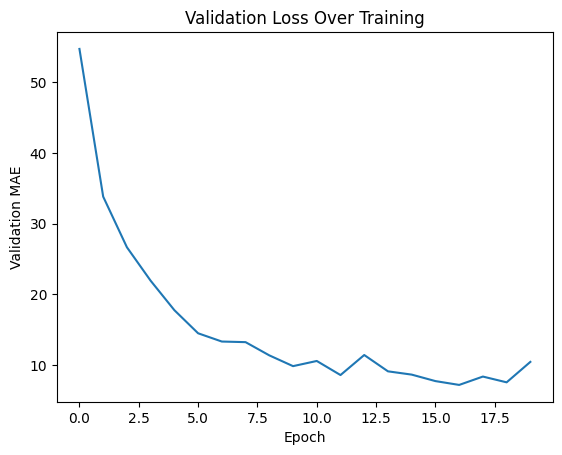

In [16]:
import matplotlib.pyplot as plt

# Printing out the final MAE in our validation sample
print(mae_history[-1])

plt.plot(mae_history)
plt.ylabel('Validation MAE')
plt.xlabel('Epoch')
plt.title('Validation Loss Over Training')
plt.show()